In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. Install Dependencies and Bring in Data

In [2]:
# Data Taken from Kaggle "Toxic Comment Classification Challenge"
# https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(
    os.path.join('/content/drive/MyDrive/Data Science WorkSpace/Deep Learning Projects/Comment Toxicity Deep Learning Model/', 'data', 'train.csv')
)

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.iloc[7]['comment_text']

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

### 1.Preprocess

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
df[df.columns[2:]].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [10]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [11]:
MAX_FEATURES = 200000 #number of words in the vocab

In [12]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode='int')

In [13]:
vectorizer.adapt(X.values)

In [14]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [15]:
# Example of vectorizer training
vectorizer('Hello World, life is great')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263, 306, ...,   0,   0,   0])>

In [16]:
vectorized_text = vectorizer(X.values)

In [17]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [18]:
len(X)

159571

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevent bottlenecks

In [20]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [21]:
batch_x.shape, batch_y.shape

((16, 1800), (16, 6))

In [22]:
len(dataset)

9974

In [23]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [24]:
train_generator = train.as_numpy_iterator()

In [25]:
train_generator.next()

(array([[  61,   59,   15, ...,    0,    0,    0],
        [   6,  371,   60, ...,    0,    0,    0],
        [  23,   12,   42, ...,    0,    0,    0],
        ...,
        [  51, 1032,    2, ...,    0,    0,    0],
        [ 185,   46,  290, ...,    0,    0,    0],
        [  76,   47,    7, ...,    0,    0,    0]]), array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

### 2. Create Sequential Model

In [26]:
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding 
from tensorflow.keras.models import Sequential 

In [27]:
model = Sequential()
#create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature Extractor Fully Connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#final layer
model.add(Dense(6, activation='sigmoid'))

In [28]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [32]:
history = model.fit(train, epochs=1, validation_data = val)

6981/6981 [==============================] - 649s 93ms/step - loss: 0.0450 - val_loss: 0.0410


In [33]:
history.history

{'loss': [0.0450204499065876], 'val_loss': [0.041012369096279144]}

In [34]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

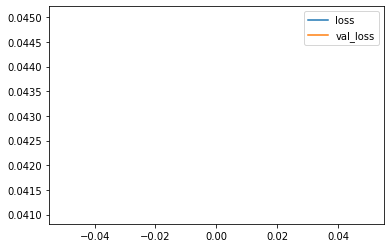

In [35]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### 3. Make Predictions

In [48]:
input_text = vectorizer('You freaking suck! I am going to hit you')

In [49]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0])>

In [50]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 61ms/step


In [51]:
res, df.columns[2:]

(array([[0.9947202 , 0.33954358, 0.95109886, 0.06506409, 0.7436003 ,
         0.18102048]], dtype=float32),
 Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
        'identity_hate'],
       dtype='object'))

In [54]:
# predicting test data
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [56]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

### 4. Evaluate Model

In [57]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [58]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [62]:
print(f'Precision: {pre.result().numpy()},Recall: {re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8127465844154358,Recall: 0.7478358149528503, Accuracy:0.5065195560455322


### 5. Test and Gradio

In [ ]:
!pip install gradio jinja2

In [64]:
import gradio as gr

In [65]:
os.chdir('/content/drive/MyDrive/Data Science WorkSpace/Deep Learning Projects/Comment Toxicity Deep Learning Model/')

In [66]:
model.save('toxicity.h5')

In [73]:
input_str = vectorizer('hey i freaking hate you! I am coming for you. I am going to hurt you!')
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 62ms/step


In [75]:
res , df.columns[2:]

(array([[0.8399806 , 0.10845311, 0.43790162, 0.12174788, 0.5372088 ,
         0.21842653]], dtype=float32),
 Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
        'identity_hate'],
       dtype='object'))

In [78]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    return text

In [79]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment To Score'),
                         outputs='text')

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [80]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://d5226a6ee0d80593.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f2e776c6850>,
 'http://127.0.0.1:7860/',
 'https://d5226a6ee0d80593.gradio.app')